# Import model and dataset

In [1]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import Flowers102
from torchvision.transforms import transforms
from torch.optim import lr_scheduler


import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
import copy
import time

import torch.nn as nn
import torch.optim as optim

In [2]:
# set to GPU if its available

device = torch.device('cpu')
if torch.cuda.is_available():
    print(f'Found {torch.cuda.device_count()} GPUs.')
    device = torch.device('cuda:0')
print(f'The device is set to {device}')


Found 1 GPUs.
The device is set to cuda:0


# Load model and image dataset

In [3]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [4]:
training_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # For GPU purpose
    # As we are going to do transfer learning with a ImageNet pretrained VGG
    # so here we normalize the dataset being used here with the ImageNet stats
    # for better transfer learning performance
    transforms.Normalize([0.485, 0.456, 0.406], # RGB mean & std estied on ImageNet
                         [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # RGB mean & std estied on ImageNet
                         [0.229, 0.224, 0.225])
])


training_set = Flowers102('./data', split='train', transform=training_transforms, download=True)
validation_set = Flowers102('./data', split='val', transform=validation_transforms, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=0)

dataloaders = {'train': training_loader, 'val': validation_loader}
dataset_sizes = {'train': len(training_set), 'val': len(validation_set)}

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 1020 instances
Validation set has 1020 instances


### Sanity Check (Display images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 9, 92, 64, 87])
yellow iris  canna lily  californian poppy  tree mallow


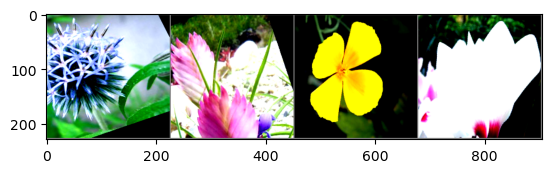

In [5]:
# Helper function for inline image display
def matplotlib_imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# from https://github.com/bdevnani3/oxfordflowers102-label-name-mapping/blob/main/mapping.json
with open('label_to_name2.json', 'r') as f:
    flower_to_name = json.load(f)


flower_to_name = dict((v,k) for k,v in flower_to_name.items())
dataiter = iter(training_loader)
images, labels = next(dataiter)
print(labels[0:4])
# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('  '.join(flower_to_name[labels[j].item()] for j in range(4)))

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {flower_to_name[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(flower_to_name))

model_ft = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

In [14]:
# train model using transfer learning
model_tl = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 0/9
----------


KeyboardInterrupt: 

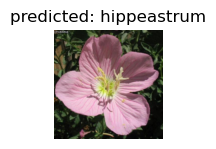

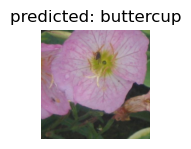

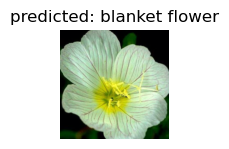

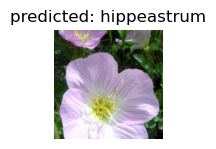

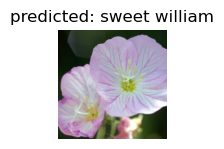

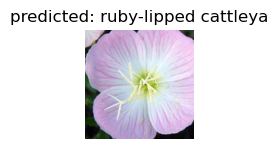

In [17]:
visualize_model(model_tl)

In [ ]:
model.class_to_idx = training_set['train'].class_to_idx
model.cpu()
torch.save({'arch': 'resNet50',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            'resNet50classifier.pth')